# k-최근접 이웃 회귀

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/3-1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 데이터 준비

In [4]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime
from datetime import date

In [5]:
from matplotlib import rc
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location = './NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

# 데이터 불러오기

In [6]:
df_stock = pd.read_csv("C:\\Users\\Hi\\JupyterProjects\\JupyterML\\Covid\\data\\covid19_kor\\주식시장_일별__20220415170553.csv", encoding='euc-kr')
df_covid = pd.read_csv("C:\\Users\\Hi\\JupyterProjects\\JupyterML\\Covid\\data\\covid19_kor\\서울특별시 코로나19 자치구별 확진자 발생동향.csv", encoding='euc-kr')

# 데이터 확인

In [7]:
df_stock.head()

,계정별,2020.02.05,2020.02.06,2020.02.07,2020.02.10,2020.02.11,2020.02.12,2020.02.13,2020.02.14,2020.02.17,...,2022.02.04,2022.02.07,2022.02.08,2022.02.09,2022.02.10,2022.02.11,2022.02.14,2022.02.15,2022.02.16,2022.02.17
0,KOSPI지수 (1980.01.04=100),2165.63,2227.94,2211.95,2201.07,2223.12,2238.38,2232.96,2243.59,2242.17,...,2750.26,2745.06,2746.47,2768.85,2771.93,2747.71,2704.48,2676.54,2729.68,2744.09
1,"거래량(주식시장, 잠정치) (만주)",56312.00,68323.00,76671.00,60047.00,51031.00,62342.00,62961.00,58900.00,45309.00,...,52652.00,41008.00,55489.00,52969.00,50043.00,45698.00,60566.00,57535.00,41515.00,60226.00
2,"거래대금(주식시장 , 잠정치) (억원)",74625.00,80636.00,69263.00,53322.00,64744.00,67750.00,79571.00,61331.00,55661.00,...,111842.00,111059.00,116203.00,101579.00,125638.00,105400.00,113138.00,92255.00,82633.00,116773.00
3,"외국인 순매수(주식시장, 잠정치) (억원)",4578.00,1586.00,223.00,-3039.00,-934.00,-2163.00,2795.00,945.00,-2287.00,...,1945.00,-69.00,-939.00,2355.00,8365.00,6081.00,684.00,-2209.00,-437.00,6516.00
4,"주식시장-거래량(만주, 시간외거래분 포함) (만주)",57440.00,69522.00,80034.00,60957.00,52621.00,63246.00,63867.00,59722.00,45825.00,...,53615.00,41784.00,56053.00,53912.00,50961.00,48052.00,61634.00,58904.00,42237.00,-


In [8]:
df_covid.head()

,자치구 기준일,종로구 전체,종로구 추가,중구 전체,중구 추가,용산구 전체,용산구 추가,성동구 전체,성동구 추가,광진구 전체,...,서초구 전체,서추구 추가,강남구 전체,강남구 추가,송파구 전체,송파구 추가,강동구 전체,강동구 추가,기타 전체,기타 추가
0,2022.02.17.00,6850,246,6313,221,10242,405,11930,804,15729,...,17646,784,25413,1169,28864,1218,20800,1064,31146,1254
1,2022.02.16.00,6604,227,6092,179,9837,340,11126,639,14865,...,16862,764,24244,1040,27646,1356,19736,1180,29892,898
2,2022.02.15.00,6377,182,5913,136,9497,218,10487,316,14122,...,16098,440,23204,819,26290,682,18556,528,28994,844
3,2022.02.14.00,6195,96,5777,91,9279,256,10171,336,13669,...,15658,386,22385,632,25608,726,18028,588,28150,735
4,2022.02.13.00,6099,184,5686,111,9023,248,9835,408,13192,...,15272,430,21753,747,24882,800,17440,664,27416,728


# Covid

In [9]:
# 데이터 전처리 - 종로구 데이터 추출
df_covid = df_covid[['자치구 기준일', '종로구 전체']]

In [10]:
# 데이터 전처리 - 날짜 형식 변환
date_set=[]
remove_set = ['2020-04-15', '2020-04-30', '2020-05-01', '2020-05-05', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-09', '2020-12-25', '2020-12-31', '2021-01-01', '2021-02-11', '2021-02-12', '2021-03-01', '2021-05-05', '2021-05-19', '2021-08-16', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-04', '2021-10-11', '2021-12-31', '2022-01-31', '2022-02-01', '2022-02-02']
for item in df_covid['자치구 기준일']:
    break_flag = 1
    # print(item)
    item=item.split('.')
    year=int(item[0])
    month=int(item[1])
    day=int(item[2])
    for remove_data in remove_set:
        if(remove_data == str(date(year, month, day)) or date(year, month, day).weekday() > 4):
            date_set+=[np.nan]
            break_flag = 0
            break
    if(break_flag == 1):
        date_set+=[str(date(year,month,day))]
        # print(datetime.date(year,month,day))
df_covid['자치구 기준일'] = date_set
# df_covid['자치구 기준일'] = pd.to_datetime(df_covid['자치구 기준일'])

df_covid.dropna(axis=0, inplace = True)
df_covid = df_covid.drop_duplicates(['자치구 기준일'])
df_covid["종로구 전체"]=df_covid["종로구 전체"].apply(float)
df_covid = df_covid.sort_values('자치구 기준일', ascending = True)

# print(type(remove_set[0]))
# print(type(str(date(year, month, day))))
# print(str(date(year, month, day)))

# dropna는 행(열) 중 에서 결측치가 존재하는 행(열)을 제거한다.
# axis = 0이면 행을 제거하고 axis = 1이면 열을 제거한다.
# thresh = N 옵션을 주면 해당 행(열)에 N개 이상의 값이 존재하면 결측치가 존재해도 행(열)을 제거하지 않는다.
# inplace = True 옵션을 주면 항구적 적용이 가능하다.

In [11]:
# 확인용 코드
print(len(remove_set))

27


In [12]:
# 확인용 코드
df_covid['자치구 기준일']

744    2020-02-05
743    2020-02-06
742    2020-02-07
739    2020-02-10
738    2020-02-11
          ...    
6      2022-02-11
3      2022-02-14
2      2022-02-15
1      2022-02-16
0      2022-02-17
Name: 자치구 기준일, Length: 505, dtype: object

In [13]:
# 확인용 코드
df_covid.head(3)

,자치구 기준일,종로구 전체
744,2020-02-05,3.0
743,2020-02-06,3.0
742,2020-02-07,0.0


In [14]:
# 확인용 코드
df_covid.tail(3)

,자치구 기준일,종로구 전체
2,2022-02-15,6377.0
1,2022-02-16,6604.0
0,2022-02-17,6850.0


In [15]:
# 확인용 코드
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 744 to 0
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   자치구 기준일  505 non-null    object 
 1   종로구 전체   505 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.8+ KB


# Stock

In [16]:
# 확인용 코드
df_stock.head()

,계정별,2020.02.05,2020.02.06,2020.02.07,2020.02.10,2020.02.11,2020.02.12,2020.02.13,2020.02.14,2020.02.17,...,2022.02.04,2022.02.07,2022.02.08,2022.02.09,2022.02.10,2022.02.11,2022.02.14,2022.02.15,2022.02.16,2022.02.17
0,KOSPI지수 (1980.01.04=100),2165.63,2227.94,2211.95,2201.07,2223.12,2238.38,2232.96,2243.59,2242.17,...,2750.26,2745.06,2746.47,2768.85,2771.93,2747.71,2704.48,2676.54,2729.68,2744.09
1,"거래량(주식시장, 잠정치) (만주)",56312.00,68323.00,76671.00,60047.00,51031.00,62342.00,62961.00,58900.00,45309.00,...,52652.00,41008.00,55489.00,52969.00,50043.00,45698.00,60566.00,57535.00,41515.00,60226.00
2,"거래대금(주식시장 , 잠정치) (억원)",74625.00,80636.00,69263.00,53322.00,64744.00,67750.00,79571.00,61331.00,55661.00,...,111842.00,111059.00,116203.00,101579.00,125638.00,105400.00,113138.00,92255.00,82633.00,116773.00
3,"외국인 순매수(주식시장, 잠정치) (억원)",4578.00,1586.00,223.00,-3039.00,-934.00,-2163.00,2795.00,945.00,-2287.00,...,1945.00,-69.00,-939.00,2355.00,8365.00,6081.00,684.00,-2209.00,-437.00,6516.00
4,"주식시장-거래량(만주, 시간외거래분 포함) (만주)",57440.00,69522.00,80034.00,60957.00,52621.00,63246.00,63867.00,59722.00,45825.00,...,53615.00,41784.00,56053.00,53912.00,50961.00,48052.00,61634.00,58904.00,42237.00,-


In [17]:
# 데이터 전처리 - 전치 + 날짜 형식 변환
df_stock_day = df_stock.columns.values.tolist()
df_stock = df_stock.T
# print(df_stock.T.head())
df_stock['날짜'] = df_stock_day

In [18]:
date_set=[]
for item in df_stock['날짜']:
    # print(item)
    if(item == '계정별'):
        date_set+=[np.nan]
    else:
        item=item.split('.')
        year=int(item[0])
        month=int(item[1])
        day=int(item[2])
        date_set+=[str(date(year,month,day))]
    # print(datetime.date(year,month,day))
df_stock['날짜'] = date_set
# df_stock['날짜'] = pd.to_datetime(df_stock['날짜'])

df_stock.dropna(axis=0, inplace = True)
df_stock.rename(columns={0:'KOSPI'}, inplace = True)
df_stock = df_stock[['KOSPI', '날짜']]
df_stock["KOSPI"]=df_stock["KOSPI"].apply(float)
df_stock = df_stock.sort_values('날짜', ascending = True)

In [19]:
# 확인용 코드
df_stock.head(3)

,KOSPI,날짜
2020.02.05,2165.63,2020-02-05
2020.02.06,2227.94,2020-02-06
2020.02.07,2211.95,2020-02-07


In [20]:
# 확인용 코드
df_stock.tail(3)

,KOSPI,날짜
2022.02.15,2676.54,2022-02-15
2022.02.16,2729.68,2022-02-16
2022.02.17,2744.09,2022-02-17


In [21]:
# 확인용 코드
df_covid.head(3)

,자치구 기준일,종로구 전체
744,2020-02-05,3.0
743,2020-02-06,3.0
742,2020-02-07,0.0


In [22]:
# 확인용 코드
df_covid.tail(3)

,자치구 기준일,종로구 전체
2,2022-02-15,6377.0
1,2022-02-16,6604.0
0,2022-02-17,6850.0


In [23]:
# 확인용 코드
list1 = list(np.array(df_covid['자치구 기준일'].tolist()))
print(len(set(list1)))

505


In [24]:
# 확인용 코드
list2 = list(np.array(df_stock['날짜'].tolist()))
print(len(set(list1)))

505


In [25]:
# 확인용 코드
C = list(set(list1) - set(list2))
D = list(set(list2) - set(list1))
print(C)
print(D)

[]
[]


In [26]:
# 확인용 코드
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505 entries, 2020.02.05 to 2022.02.17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOSPI   505 non-null    float64
 1   날짜      505 non-null    object 
dtypes: float64(1), object(1)
memory usage: 11.8+ KB


In [27]:
# 확인용 코드
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 744 to 0
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   자치구 기준일  505 non-null    object 
 1   종로구 전체   505 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.8+ KB


# 시각화

In [28]:
import matplotlib.pyplot as plt

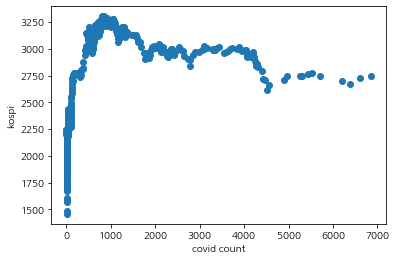

In [29]:
# 시각화
df_covid_count = df_covid['종로구 전체']
df_kospi = df_stock['KOSPI']
plt.scatter(df_covid_count, df_kospi)
plt.xlabel('covid count')
plt.ylabel('kospi')
plt.show()

## 데이터셋 분류

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df_covid_count

744       3.0
743       3.0
742       0.0
739       0.0
738       0.0
        ...  
6      5700.0
3      6195.0
2      6377.0
1      6604.0
0      6850.0
Name: 종로구 전체, Length: 505, dtype: float64

In [32]:
df_kospi

2020.02.05    2165.63
2020.02.06    2227.94
2020.02.07    2211.95
2020.02.10    2201.07
2020.02.11    2223.12
               ...   
2022.02.11    2747.71
2022.02.14    2704.48
2022.02.15    2676.54
2022.02.16    2729.68
2022.02.17    2744.09
Name: KOSPI, Length: 505, dtype: float64

In [33]:
# 데이터셋 분류
train_input, test_input, train_target, test_target = train_test_split(
    df_covid_count, df_kospi, test_size = 0.25,  random_state=42)

In [34]:
print(train_input.shape, test_input.shape)

(378,) (127,)


In [35]:
# test_array = np.array([1,2,3,4])
# print(test_array.shape)

In [36]:
# test_array = test_array.reshape(2, 2)
# print(test_array.shape)

In [37]:
# reshape 메서드 : 원본 배열의 원소 개수와 reshape 배열의 원소 개수가 다르면 에러 발생
# test_array = test_array.reshape(2, 3)

In [38]:
# 데이터셋 전처리
train_input = train_input.values.reshape(-1, 1)
test_input = test_input.values.reshape(-1, 1)

In [39]:
print(train_input.shape, test_input.shape)

(378, 1) (127, 1)


## 결정 계수 ($ R^2$)

In [40]:
from sklearn.neighbors import KNeighborsRegressor

In [41]:
# K-최근접 이웃 회귀 모델 선정 & 훈련 by 훈련 데이터
knr = KNeighborsRegressor()
knr.fit(train_input, train_target)

KNeighborsRegressor()

In [42]:
# 모델 분석 by 테스트 데이터
print(knr.score(test_input, test_target))

0.9825923736007617


In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [44]:
# 결과 예측 by 테스트 데이터
test_prediction = knr.predict(test_input)
# 평균 절댓값 오차 계산 by 테스트 데이터
mae = mean_absolute_error(test_target, test_prediction)
print(mae)

40.474614173228325


## 과대적합 vs 과소적합

In [45]:
# 모델 분석 by 훈련 데이터
print(knr.score(train_input, train_target))

0.9897364577600876


In [46]:
# 모델 수정
# - n_neighbors의 default : 5
knr.n_neighbors = 3
# K-최근접 이웃 회귀 모델 훈련
knr.fit(train_input, train_target)
print(knr.score(train_input, train_target))

0.989148531234


In [47]:
print(knr.score(test_input, test_target))

0.9812966987559789


In [48]:
# 결과 예측 by 테스트 데이터
test_prediction = knr.predict(test_input)
# 평균 절댓값 오차 계산 by 테스트 데이터
mae = mean_absolute_error(test_target, test_prediction)
print(mae)

36.68144356955381


## 확인문제

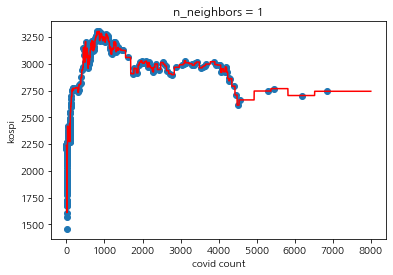

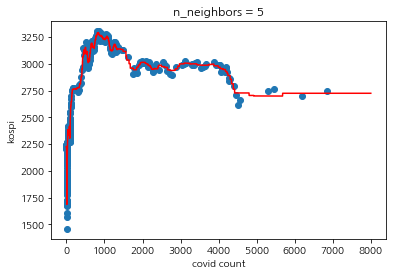

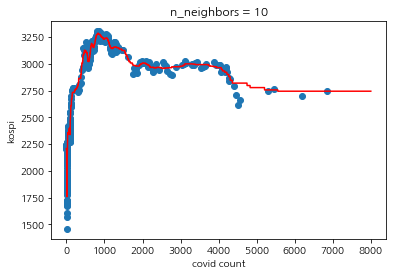

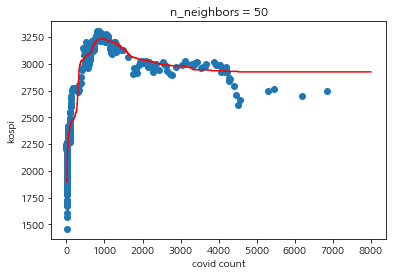

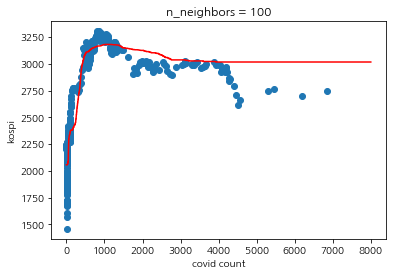

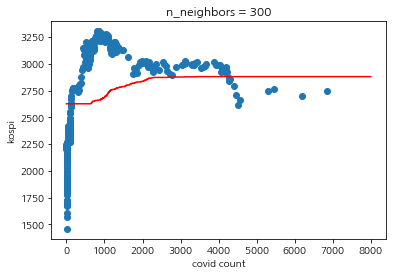

In [49]:
# k-최근접 이웃 회귀 객체를 만듭니다
knr = KNeighborsRegressor()
# x 좌표를 만듭니다
x = np.arange(0, 8000).reshape(-1, 1)

# n = 1, 5, 10일 때 예측 결과를 그래프로 그립니다.
for n in [1, 5, 10, 50, 100, 300]:
    # 모델 훈련
    knr.n_neighbors = n
    knr.fit(train_input, train_target)
    # 지정한 범위 x에 대한 예측 구하기 
    prediction = knr.predict(x)
    # 훈련 세트와 예측 결과 그래프 그리기
    plt.scatter(train_input, train_target)
    plt.plot(x, prediction, 'r')
    plt.title('n_neighbors = {}'.format(n))    
    plt.xlabel('covid count')
    plt.ylabel('kospi')
    plt.show()

MAE : 39.701
MSE : 6209.617
RMSE : 78.801
test score : 0.974
train score : 0.985


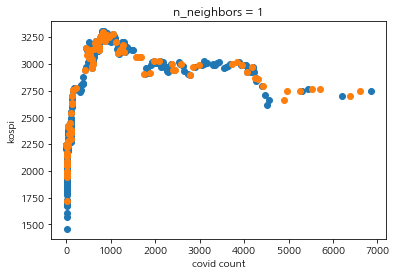

MAE : 40.475
MSE : 4214.186
RMSE : 64.917
test score : 0.983
train score : 0.990


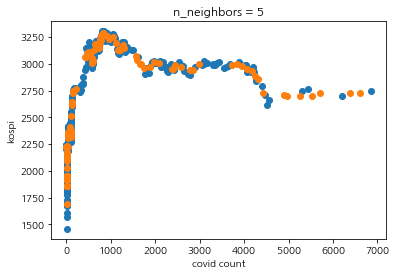

MAE : 44.237
MSE : 5049.752
RMSE : 71.062
test score : 0.979
train score : 0.986


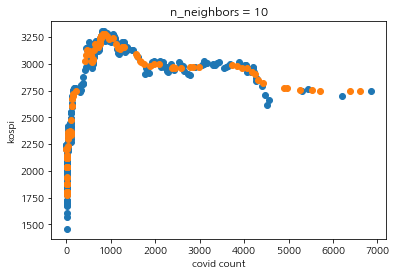

MAE : 87.150
MSE : 14536.270
RMSE : 120.566
test score : 0.940
train score : 0.949


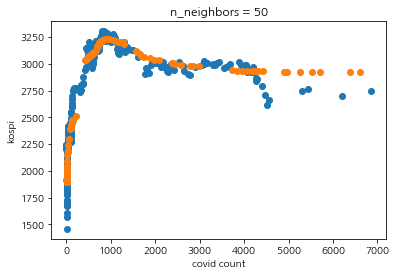

MAE : 119.434
MSE : 25996.297
RMSE : 161.234
test score : 0.893
train score : 0.904


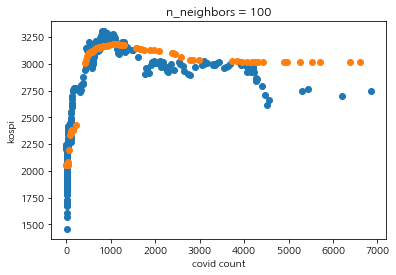

MAE : 403.858
MSE : 215783.567
RMSE : 464.525
test score : 0.109
train score : 0.115


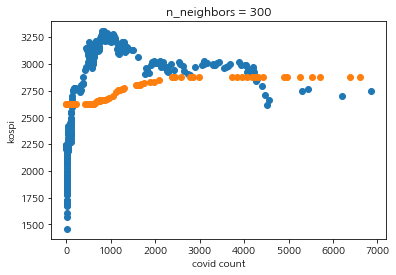

In [50]:
# K-최근접 이웃 회귀 모델 선정 & 훈련 by 훈련 데이터
knr = KNeighborsRegressor()
knr.fit(train_input, train_target)

# n = 1, 5, 10일 때 예측 결과를 그래프로 그립니다.
for n in [1, 5, 10, 50, 100, 300]:
    # 모델 훈련
    knr.n_neighbors = n
    knr.fit(train_input, train_target)
    # 결과 예측 by 테스트 데이터
    test_prediction = knr.predict(test_input)
    # 평균 오차 계산 by 테스트 데이터
    mae = mean_absolute_error(test_target, test_prediction)
    mse = mean_squared_error(test_target, test_prediction)
    rmse = np.sqrt(mse)
    print('MAE : {0:.3f}'.format(mae))
    print('MSE : {0:.3f}'.format(mse))
    print('RMSE : {0:.3f}'.format(rmse))
    # 모델분석(결정계수) by 테스트 데이터 & 테스트 데이터
    print('test score : {0:.3f}'.format(knr.score(test_input, test_target)))
    print('train score : {0:.3f}'.format(knr.score(train_input, train_target)))
    # 훈련 세트와 예측 결과 그래프 그리기
    plt.scatter(train_input, train_target)
    plt.scatter(test_input, test_prediction)
    plt.title('n_neighbors = {}'.format(n))
    plt.xlabel('covid count')
    plt.ylabel('kospi')
    plt.show()